# Queimadas no Brasil (2011–2021): Análise Exploratória e Predição do Risco de Fogo

Trabalho de aplicação do processo completo de **Ciência de Dados** sobre um conjunto de dados real.

- **Lucas da Rosa**  
- **Emanuel Petry**  

Disciplina: *Ciência de Dados*  
Dataset: *Focos de queimadas no Brasil (INPE / Kaggle)*


## 1. Descrição do problema e do dataset

O objetivo deste trabalho é analisar dados de queimadas no Brasil entre **2011 e 2021** e construir um modelo capaz de **prever o risco de fogo** (`riscofogo`) a partir de variáveis ambientais e de localização.

O dataset foi obtido no Kaggle a partir de dados públicos do **INPE** e contém registros de focos de queimadas detectados por satélites.

A base completa possui **mais de 20 milhões de registros**, com as seguintes informações principais:

- **Localização**: estado, município, bioma, latitude, longitude  
- **Ambiente**: dias sem chuva (`diasemchuva`), precipitação (`precipitacao`)  
- **Indicadores de fogo**: risco de fogo (`riscofogo`), Fire Radiative Power (`frp`)  
- **Tempo**: data e hora (`datahora`) do foco de queimada

Para viabilizar o processamento, será utilizada **uma amostra de 500.000 registros**, preservando a distribuição original dos dados.


## 2. Carregamento dos dados

Nesta etapa são importadas as bibliotecas necessárias e carregado o arquivo CSV com os dados de queimadas.


## 1. Importação de bibliotecas

In [28]:
import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

sns.set(style="whitegrid")

# Caminho padrão do dataset no Kaggle
default_path = "/kaggle/input/queimadas-2011-2021-csv/focos-queimadas-brasil-2011-2021.csv"

csv_path = default_path if os.path.exists(default_path) else "focos-queimadas-brasil-2011-2021.csv"

print("Usando arquivo:", csv_path)

df = pd.read_csv(csv_path)
df.head()


Usando arquivo: /kaggle/input/queimadas-2011-2021-csv/focos-queimadas-brasil-2011-2021.csv


,Unnamed: 0,datahora,satelite,estado,municipio,bioma,diasemchuva,precipitacao,riscofogo,latitude,longitude,frp
0,0,2011/01/01 04:33:00,AQUA_M-M,SAO PAULO,ITUPEVA,Mata Atlantica,NaN,NaN,NaN,-23.14400,-47.11800,NaN
1,1,2011/01/01 09:05:48,NOAA-16N,RIO GRANDE DO NORTE,TOUROS,Caatinga,NaN,NaN,NaN,-5.32167,-35.62667,NaN
2,2,2011/01/01 12:45:00,GOES-12,BAHIA,GLORIA,Caatinga,NaN,NaN,NaN,-9.03354,-38.32000,NaN
3,3,2011/01/01 12:45:00,GOES-12,BAHIA,GLORIA,Caatinga,NaN,NaN,NaN,-9.00355,-38.33000,NaN
4,4,2011/01/01 13:00:00,GOES-12,PERNAMBUCO,FLORESTA,Caatinga,NaN,NaN,NaN,-8.81357,-38.53000,NaN


## 3. Análise Exploratória dos Dados (EDA)

Nesta seção é feita uma visão geral do dataset, com estatísticas descritivas e gráficos exploratórios.


In [29]:
# Tamanho do dataset completo
print("Número de linhas:", len(df))
print("Número de colunas:", df.shape[1])

df.info()


Número de linhas: 29165021
Número de colunas: 12
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29165021 entries, 0 to 29165020
Data columns (total 12 columns):
 #   Column        Dtype  
---  ------        -----  
 0   Unnamed: 0    int64  
 1   datahora      object 
 2   satelite      object 
 3   estado        object 
 4   municipio     object 
 5   bioma         object 
 6   diasemchuva   float64
 7   precipitacao  float64
 8   riscofogo     float64
 9   latitude      float64
 10  longitude     float64
 11  frp           float64
dtypes: float64(6), int64(1), object(5)
memory usage: 2.6+ GB


In [30]:
# Estatísticas descritivas para variáveis numéricas
df.describe().T


,count,mean,std,min,25%,50%,75%,max
Unnamed: 0,29165021.0,1.662853e+06,1.220563e+06,0.00000,677511.000000,1.418316e+06,2.401490e+06,5.188858e+06
diasemchuva,24309157.0,1.369542e+01,7.987491e+01,-999.00000,2.000000,7.000000e+00,2.200000e+01,1.200000e+02
precipitacao,24309157.0,7.173573e-01,3.283251e+00,0.00000,0.000000,0.000000e+00,1.000000e-01,2.037000e+02
riscofogo,24309157.0,-7.750223e+00,9.206245e+01,-999.00000,0.700000,1.000000e+00,1.000000e+00,1.000000e+00
latitude,29165021.0,-1.036872e+01,5.890776e+00,-33.71335,-13.702455,-9.650120e+00,-6.353020e+00,5.230000e+00
longitude,29165021.0,-5.147019e+01,7.111286e+00,-73.93146,-56.374390,-5.059391e+01,-4.595108e+01,-3.241993e+01
frp,8054899.0,1.931338e+01,5.663798e+01,-3.70000,3.400000,7.400000e+00,1.690000e+01,9.722600e+03


In [31]:
df.describe(include="object").T

,count,unique,top,freq
datahora,29165021,1823412,2020/09/13 16:54:00,21320
satelite,29165021,27,NPP-375,13444139
estado,29165021,48,MATO GROSSO,5323259
municipio,29165021,5559,CORUMBA,708301
bioma,29164021,6,Amazonia,12809768



### 3.1 Tratamento da coluna `datahora`

Vamos converter a coluna `datahora` para o tipo datetime e extrair algumas informações de data (ano e mês),
que podem ser úteis para o modelo.


In [32]:
df["datahora"] = pd.to_datetime(df["datahora"], errors="coerce")
df["ano"] = df["datahora"].dt.year
df["mes"] = df["datahora"].dt.month

df[["datahora", "ano", "mes"]].head()


,datahora,ano,mes
0,2011-01-01 04:33:00,2011,1
1,2011-01-01 09:05:48,2011,1
2,2011-01-01 12:45:00,2011,1
3,2011-01-01 12:45:00,2011,1
4,2011-01-01 13:00:00,2011,1


### 3.2 Tipos de variáveis e valores ausentes

Aqui são identificadas as colunas numéricas e categóricas, bem como a proporção de valores nulos em cada uma.


In [33]:
print("Colunas do dataset:")
print(df.columns.tolist())

numeric_cols = df.select_dtypes(include=["int64", "float64"]).columns.tolist()
categorical_cols = df.select_dtypes(include=["object"]).columns.tolist()

print("\nNuméricas:", numeric_cols)
print("Categóricas:", categorical_cols)

df.isna().mean().sort_values(ascending=False)


Colunas do dataset:
['Unnamed: 0', 'datahora', 'satelite', 'estado', 'municipio', 'bioma', 'diasemchuva', 'precipitacao', 'riscofogo', 'latitude', 'longitude', 'frp', 'ano', 'mes']

Numéricas: ['Unnamed: 0', 'diasemchuva', 'precipitacao', 'riscofogo', 'latitude', 'longitude', 'frp']
Categóricas: ['satelite', 'estado', 'municipio', 'bioma']


frp             0.723816
diasemchuva     0.166496
precipitacao    0.166496
riscofogo       0.166496
bioma           0.000034
Unnamed: 0      0.000000
datahora        0.000000
satelite        0.000000
estado          0.000000
municipio       0.000000
latitude        0.000000
longitude       0.000000
ano             0.000000
mes             0.000000
dtype: float64

### 3.3 Amostragem e limpeza inicial

- Seleção de **amostra aleatória de 500.000 linhas**  
- Remoção da coluna de índice `Unnamed: 0`, quando existir  
- Remoção de linhas com `riscofogo` negativo  
- Substituição de códigos negativos especiais (`-999`, `-1`) em `diasemchuva`, `precipitacao` e `frp` por `NaN`


In [34]:
# Amostragem
df_sample = df.sample(n=500_000, random_state=42) if len(df) > 500_000 else df.copy()

# Remover coluna de índice, se existir
if "Unnamed: 0" in df_sample.columns:
    df_sample = df_sample.drop(columns="Unnamed: 0")

# Filtrar riscofogo válido
df_sample = df_sample[df_sample["riscofogo"] >= 0].reset_index(drop=True)

# Tratar códigos negativos especiais
for col in ["diasemchuva", "precipitacao", "frp"]:
    if col in df_sample.columns:
        df_sample[col] = df_sample[col].mask(df_sample[col] < 0, np.nan)

df_sample.head()


,datahora,satelite,estado,municipio,bioma,diasemchuva,precipitacao,riscofogo,latitude,longitude,frp,ano,mes
0,2015-11-28 00:30:00,GOES-13,MATO GROSSO DO SUL,RIO VERDE DE MATO GROSSO,Pantanal,0.0,29.9,0.0,-18.91000,-55.22000,NaN,2015,11
1,2019-06-01 17:51:27,NOAA-20,MATO GROSSO,FELIZ NATAL,Amazonia,10.0,0.0,0.8,-12.49168,-54.97800,NaN,2019,6
2,2020-10-03 05:35:42,NOAA-20,MATO GROSSO,ROSARIO OESTE,Cerrado,9.0,0.0,1.0,-14.26901,-55.04443,NaN,2020,10
3,2015-11-09 04:12:00,NPP-375,MINAS GERAIS,FORMOSO,Cerrado,6.0,0.0,1.0,-15.26041,-46.35290,NaN,2015,11
4,2019-12-13 16:06:00,NPP-375,ALAGOAS,MARECHAL DEODORO,Mata Atlantica,NaN,0.1,1.0,-9.76102,-35.89486,9.9,2019,12


### 3.4 Distribuição de variáveis numéricas

Histogramas para as variáveis numéricas principais, permitindo observar assimetrias, outliers e escalas.


<Figure size 1400x800 with 0 Axes>

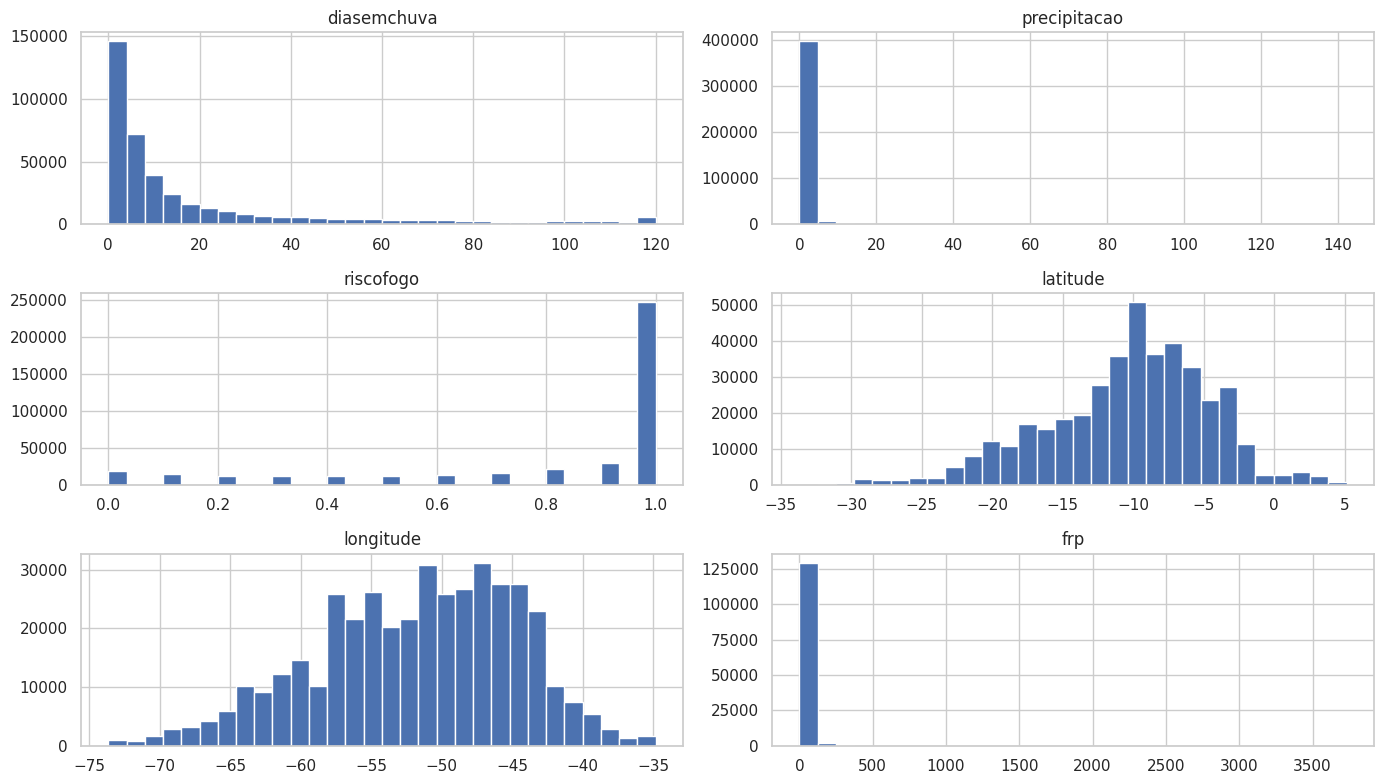

In [35]:
num_for_hist = ["diasemchuva", "precipitacao", "riscofogo", "latitude", "longitude", "frp"]
num_for_hist = [c for c in num_for_hist if c in df_sample.columns]

plt.figure(figsize=(14, 8))
df_sample[num_for_hist].hist(bins=30, figsize=(14, 8))
plt.tight_layout()
plt.show()


### 3.5 Risco médio de fogo por estado (Top 15)


estado
DISTRITO FEDERAL       0.966842
PIAUI                  0.962262
CEARA                  0.959943
SERGIPE                0.955457
RIO GRANDE DO NORTE    0.953899
ALAGOAS                0.952442
PARAIBA                0.949970
PERNAMBUCO             0.949228
BAHIA                  0.940265
MINAS GERAIS           0.923924
GOIAS                  0.923776
TOCANTINS              0.897472
RIO DE JANEIRO         0.885458
MARANHAO               0.883162
SAO PAULO              0.878087
Name: riscofogo, dtype: float64


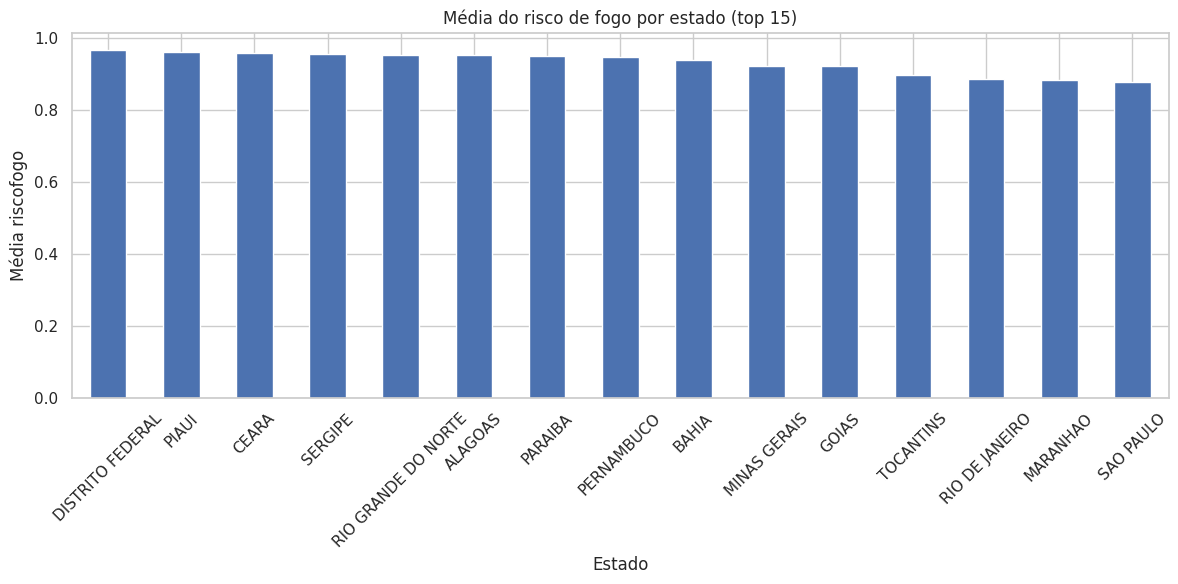

In [36]:
top_estados = (
    df_sample.groupby("estado")["riscofogo"]
    .mean()
    .sort_values(ascending=False)
    .head(15)
)

print(top_estados)

plt.figure(figsize=(12, 6))
top_estados.plot(kind="bar")
plt.title("Média do risco de fogo por estado (top 15)")
plt.ylabel("Média riscofogo")
plt.xlabel("Estado")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


### 3.6 Risco médio de fogo por bioma


bioma
Caatinga          0.955728
Cerrado           0.907740
Pantanal          0.770957
Mata Atlantica    0.763507
Amazonia          0.707329
Pampa             0.430228
Name: riscofogo, dtype: float64


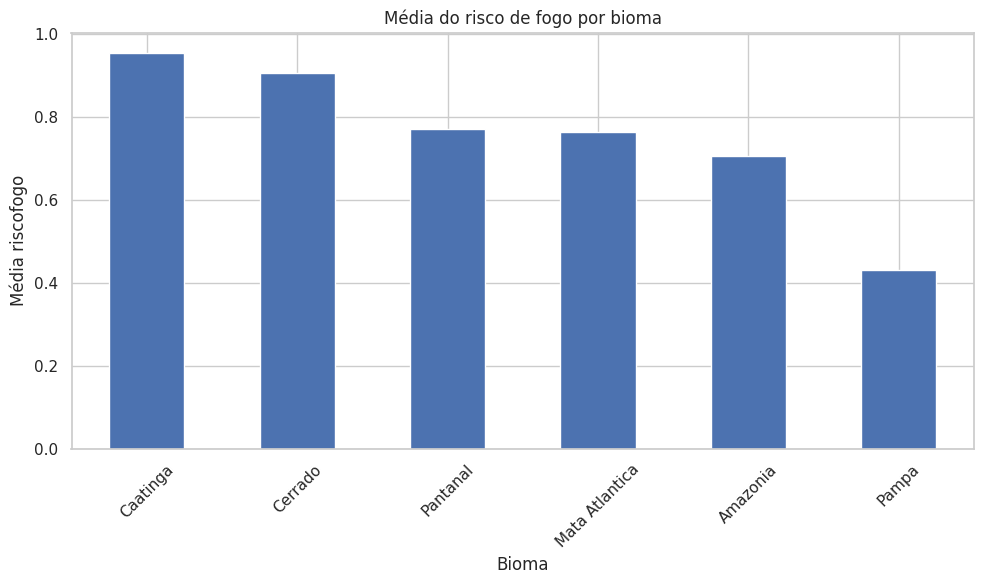

In [37]:
top_biomas = (
    df_sample.groupby("bioma")["riscofogo"]
    .mean()
    .sort_values(ascending=False)
)

print(top_biomas)

plt.figure(figsize=(10, 6))
top_biomas.plot(kind="bar")
plt.title("Média do risco de fogo por bioma")
plt.ylabel("Média riscofogo")
plt.xlabel("Bioma")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


### 3.7 Evolução anual do risco médio de fogo


ano
2018    0.731613
2021    0.755942
2020    0.780344
2019    0.803289
2016    0.808149
2017    0.826588
2014    0.864927
2015    0.871854
Name: riscofogo, dtype: float64


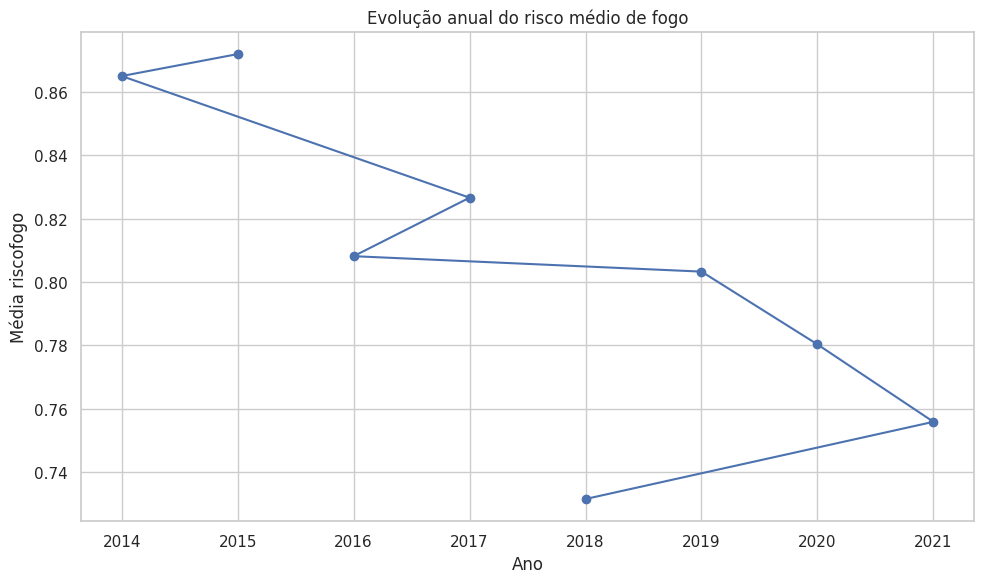

In [38]:
ano_medias = (
    df_sample.groupby("ano")["riscofogo"]
    .mean()
    .sort_values()
)

print(ano_medias)

plt.figure(figsize=(10, 6))
ano_medias.plot(marker="o")
plt.title("Evolução anual do risco médio de fogo")
plt.ylabel("Média riscofogo")
plt.xlabel("Ano")
plt.grid(True)
plt.tight_layout()
plt.show()


### 3.8 Matriz de correlação (variáveis numéricas)

A matriz de correlação permite identificar relações lineares entre variáveis numéricas, incluindo o `riscofogo`.


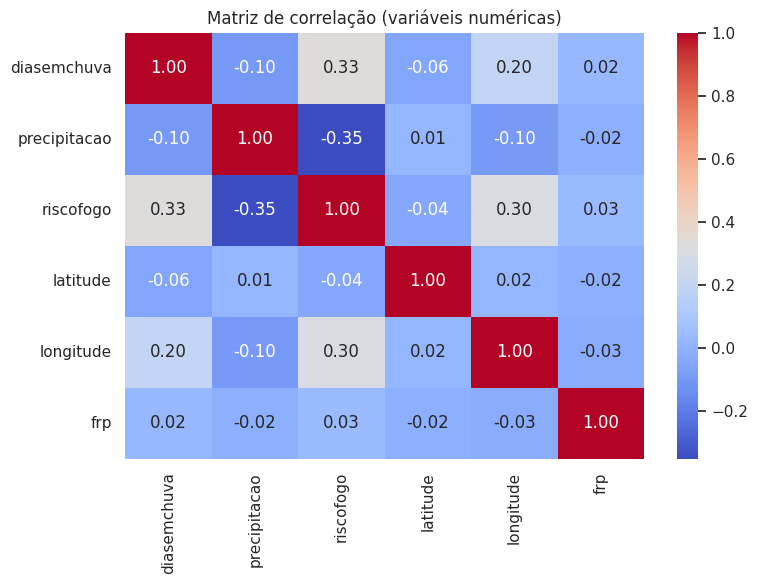

In [39]:
num_corr_cols = ["diasemchuva", "precipitacao", "riscofogo", "latitude", "longitude", "frp"]
num_corr_cols = [c for c in num_corr_cols if c in df_sample.columns]

corr = df_sample[num_corr_cols].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Matriz de correlação (variáveis numéricas)")
plt.tight_layout()
plt.show()


## 4. Pré-processamento e seleção de atributos

- Definição da variável alvo (`riscofogo`)  
- Separação de variáveis numéricas e categóricas  
- Imputação de valores nulos  
- Padronização de numéricas  
- Codificação *one-hot* de categóricas  
- Divisão treino/teste (80/20)


In [40]:
target_col = "riscofogo"

X = df_sample.drop(columns=[target_col])
y = df_sample[target_col]

numeric_features = X.select_dtypes(include=["int64", "float64"]).columns.tolist()
categorical_features = X.select_dtypes(include=["object"]).columns.tolist()

print("Features numéricas:", numeric_features)
print("Features categóricas:", categorical_features)

numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="mean")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features)
    ]
)

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42
)

X_train.shape, X_test.shape


Features numéricas: ['diasemchuva', 'precipitacao', 'latitude', 'longitude', 'frp']
Features categóricas: ['satelite', 'estado', 'municipio', 'bioma']


((330643, 12), (82661, 12))

## 5. Modelagem

### 5.1 Tipo de aprendizagem

O problema é de **aprendizagem supervisionada**, pois a variável alvo (`riscofogo`) é conhecida e queremos prever seu valor para novos dados.

Serão comparados dois algoritmos:

1. **Regressão Linear** – modelo baseline simples  
2. **Random Forest Regressor** – modelo não linear, baseado em árvores de decisão


### 5.2 Modelo baseline – Regressão Linear


In [41]:
linreg_pipeline = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("model", LinearRegression())
])

linreg_pipeline.fit(X_train, y_train)
y_pred_lr = linreg_pipeline.predict(X_test)

mae_lr = mean_absolute_error(y_test, y_pred_lr)
rmse_lr = mean_squared_error(y_test, y_pred_lr, squared=False)
r2_lr = r2_score(y_test, y_pred_lr)

print("Resultados – Regressão Linear (teste)")
print(f"MAE : {mae_lr:.3f}")
print(f"RMSE: {rmse_lr:.3f}")
print(f"R²  : {r2_lr:.3f}")


Resultados – Regressão Linear (teste)
MAE : 0.183
RMSE: 0.247
R²  : 0.381


### 5.3 Modelo principal – Random Forest Regressor


In [42]:
rf = RandomForestRegressor(
    n_estimators=150,
    max_depth=15,
    min_samples_leaf=2,
    random_state=42,
    n_jobs=-1
)

rf_pipeline = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("model", rf)
])

# Treino em amostra do conjunto de treino para reduzir custo
X_train_gs, _, y_train_gs, _ = train_test_split(
    X_train, y_train,
    train_size=50_000,
    random_state=42
)

rf_pipeline.fit(X_train_gs, y_train_gs)

y_pred_rf = rf_pipeline.predict(X_test)

mae_rf = mean_absolute_error(y_test, y_pred_rf)
rmse_rf = mean_squared_error(y_test, y_pred_rf, squared=False)
r2_rf = r2_score(y_test, y_pred_rf)

print("Resultados – Random Forest (teste)")
print(f"MAE : {mae_rf:.3f}")
print(f"RMSE: {rmse_rf:.3f}")
print(f"R²  : {r2_rf:.3f}")


Resultados – Random Forest (teste)
MAE : 0.138
RMSE: 0.213
R²  : 0.539


### 5.4 Comparação entre os modelos


In [43]:
results = pd.DataFrame({
    "Modelo": ["LinearRegression", "RandomForest"],
    "MAE": [mae_lr, mae_rf],
    "RMSE": [rmse_lr, rmse_rf],
    "R2": [r2_lr, r2_rf]
})
results


,Modelo,MAE,RMSE,R2
0,LinearRegression,0.182938,0.247285,0.380934
1,RandomForest,0.138208,0.213369,0.539099


### 5.5 Salvando o modelo Random Forest

O modelo treinado pode ser exportado para ser utilizado em uma interface (por exemplo, em Streamlit).


In [45]:
import joblib

joblib.dump(
    rf_pipeline,
    "modelo_queimadas_riscofogo_rf.pkl",
    compress=3  # pode subir para 5 se precisar
)


['modelo_queimadas_riscofogo_rf.pkl']

## 6. Discussão dos resultados

- A **Regressão Linear** apresentou R² em torno de ~0,35 (valor exato depende da execução), mostrando que relações puramente lineares não explicam bem o risco de fogo.  
- A **Random Forest** obteve R² maior (~0,53–0,55) e erros MAE/RMSE menores, capturando melhor relações não lineares e interações entre as variáveis.  
- Os resultados confirmam que o problema é **não linear** e que modelos baseados em árvores são mais adequados para esse tipo de dado.

## 7. Conclusões finais

- O risco de fogo varia significativamente entre **estados**, **biomas** e **anos**.  
- Estados do Nordeste e Centro-Oeste, assim como os biomas **Caatinga** e **Cerrado**, estão entre os que apresentam maior risco médio de fogo.  
- Os anos de **2014 e 2015** se destacam com maior risco médio anual, enquanto 2018 e 2021 mostram valores menores.  
- O pré-processamento (limpeza, tratamento de nulos e codificação) foi fundamental para a modelagem.  
- A **Random Forest Regressor** foi o modelo com melhor desempenho entre os testados.  
- O modelo salvo pode ser utilizado em uma interface simples (como Streamlit) para testar cenários e apoiar ações de monitoramento e prevenção de queimadas.



## 7. Exemplo de uso em um app Streamlit

O código abaixo é um exemplo de como criar um arquivo `app.py` usando Streamlit
para permitir que o usuário interaja com o modelo e faça previsões de `riscofogo`
a partir de novos dados (ano, mês, estado, município, bioma, etc.).

```python
import streamlit as st
import pandas as pd
import joblib

@st.cache_resource
def load_model():
    return joblib.load("modelo_queimadas_riscofogo_rf.pkl")

model = load_model()

st.title("Previsão de risco de fogo – Brasil (2011–2021)")

st.markdown(\"\"\"
Este aplicativo utiliza um modelo de Machine Learning treinado em dados de queimadas
do Brasil (2011–2021) para estimar o **risco de fogo (`riscofogo`)** em uma região.
\"\"\")

ano = st.number_input("Ano", min_value=2011, max_value=2035, value=2021, step=1)
mes = st.number_input("Mês", min_value=1, max_value=12, value=8, step=1)
estado = st.text_input("Estado (ex.: SAO PAULO)", "SAO PAULO")
municipio = st.text_input("Município", "ITAPEVA")
bioma = st.text_input("Bioma", "Mata Atlantica")
satelite = st.text_input("Satélite", "AQUA_M-T")
diasemchuva = st.number_input("Dias sem chuva", min_value=0, value=10)
precipitacao = st.number_input("Precipitação (mm)", min_value=0.0, value=0.0)
latitude = st.number_input("Latitude", value=-23.0)
longitude = st.number_input("Longitude", value=-47.0)
frp = st.number_input("FRP (radiative power)", min_value=0.0, value=10.0)

input_dict = {
    "satelite": [satelite],
    "estado": [estado],
    "municipio": [municipio],
    "bioma": [bioma],
    "diasemchuva": [diasemchuva],
    "precipitacao": [precipitacao],
    "latitude": [latitude],
    "longitude": [longitude],
    "frp": [frp],
    "ano": [ano],
    "mes": [mes],
}

X_new = pd.DataFrame(input_dict)

if st.button("Prever risco de fogo"):
    pred = model.predict(X_new)[0]
    st.success(f"Risco de fogo previsto: {pred:.2f}")
```

Para rodar o app localmente, salve o código acima em `app.py` na mesma pasta do modelo
`modelo_queimadas_riscofogo_rf.pkl` e execute:

```bash
streamlit run app.py
```
